## qBraid Runtime: Bloqade batch submission to QuEra Aquila

In [ ]:
%%capture

%pip install 'qbraid[bloqade,visualization]>=0.9.5'

In [10]:
import numpy as np
from bloqade.analog import var
from bloqade.analog.atom_arrangement import Square

from qbraid.transpiler import ConversionGraph
from qbraid.programs import ExperimentType
from qbraid.runtime import QbraidProvider
from qbraid.visualization import plot_histogram

Create adiabatic program batch using Bloqade

In [11]:
adiabatic_durations = [0.4, 3.2, 0.4]

max_detuning = var("max_detuning")
adiabatic_program = (
    Square(3, lattice_spacing="lattice_spacing")
    .rydberg.rabi.amplitude.uniform.piecewise_linear(
        durations=adiabatic_durations, values=[0.0, "max_rabi", "max_rabi", 0.0]
    )
    .detuning.uniform.piecewise_linear(
        durations=adiabatic_durations,
        values=[
            -max_detuning,  # scalar variables support direct arithmetic operations
            -max_detuning,
            max_detuning,
            max_detuning,
        ],
    )
    .assign(max_rabi=15.8, max_detuning=16.33)
    .batch_assign(lattice_spacing=np.arange(4.0, 7.0, 1.0))
)

Target QuEra Aquila device using QbraidProvider

In [12]:
provider = QbraidProvider()

In [13]:
device = provider.get_device("quera_aquila")

print(device.status())
print(device.profile.experiment_type)
print(device.profile.program_spec)

DeviceStatus.ONLINE
ExperimentType.AHS
ProgramSpec(AnalogHamiltonianSimulation, braket_ahs)


In [16]:
from qbraid.programs import QPROGRAM_REGISTRY

QPROGRAM_REGISTRY

{'cirq': cirq.circuits.circuit.Circuit,
 'qiskit': qiskit.circuit.quantumcircuit.QuantumCircuit,
 'pyquil': pyquil.quil.Program,
 'braket': braket.circuits.circuit.Circuit,
 'braket_ahs': braket.ahs.analog_hamiltonian_simulation.AnalogHamiltonianSimulation,
 'openqasm3': openqasm3.ast.Program,
 'qasm3': str,
 'qasm2': str,
 'qasm2_kirin': str,
 'ionq': qbraid.programs.typer.IonQDict,
 'qubo': qbraid.programs.typer.QuboCoefficientsDict,
 'bloqade': bloqade.analog.builder.assign.BatchAssign,
 'pyqir': Module,
 'pulser': pulser.sequence.sequence.Sequence}

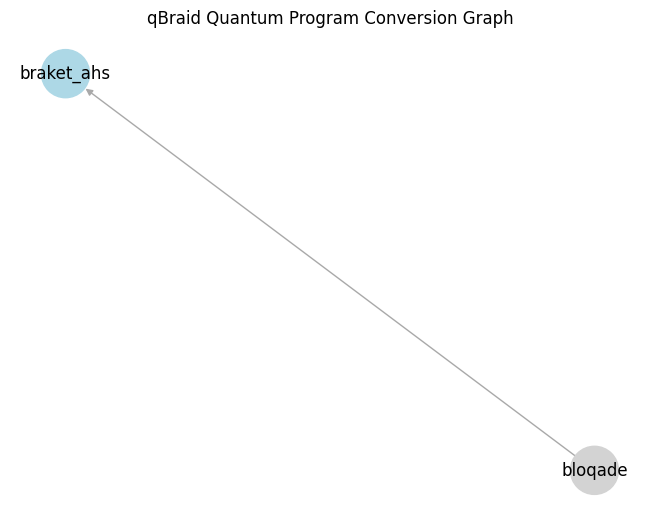

In [17]:
graph = ConversionGraph()

graph.plot(experiment_type=ExperimentType.AHS)

Submit quantum task(s)

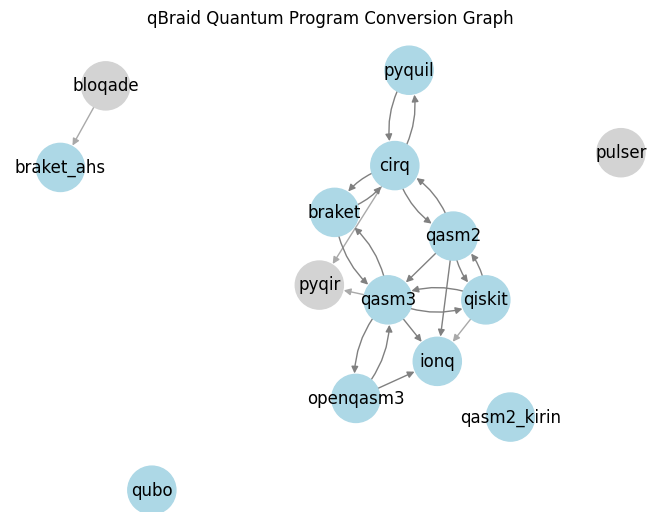

In [18]:
device.scheme.conversion_graph.plot()

In [19]:
device.set_options(validate=0)

In [20]:
from qbraid.programs import ProgramSpec

In [21]:
braket_batch = device.transpile(
    adiabatic_program, ProgramSpec(type(adiabatic_program), alias="bloqade")
)

In [23]:
job_batch = device.run(adiabatic_program, shots=10, tags={"batch": "adiabatic-test-1"})

In [64]:
print(f"{'Job Id':<60} {'Status':<15}")
print("-" * 50)
print(f"{job_batch.id:<60}{job_batch.status().name:<15}")

Job Id                                                       Status         
--------------------------------------------------
quera_aquila-vegliivost-qjob-z9wheg5f1art0n2umpjd           COMPLETED      


In [68]:
results = job_batch.result()

shot_results_batch = results.data.measurements

counts_batch = results.data.get_counts()

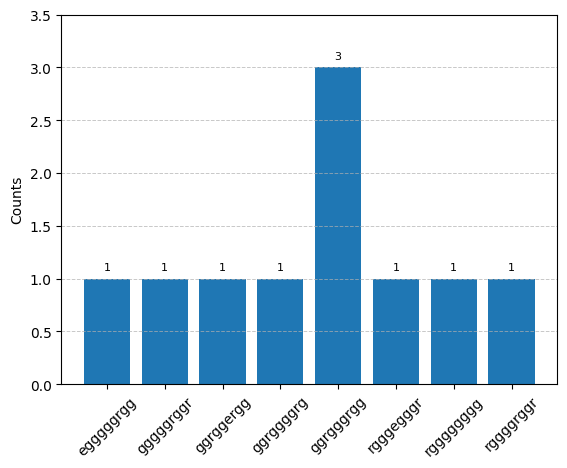

In [69]:
plot_histogram(counts_batch)